In [1]:
using Plots
using LinearAlgebra
using LsqFit

In [2]:
include("CompQM.jl")

In [3]:
module My

Base.@kwdef struct Parameters
    ħc::Float64 = 197.3 
    mc²::Float64 = 938 
    α::Float64 = 0.0072973525693 # fine-structure constant
    
    Z::Int64 
    N::Int64
    A::Int64 = Z+N
    
    # woods-saxon parameters
    a::Float64 = 0.67
    r₀::Float64 = 1.27
    R::Float64 = r₀*A^(1/3)
    V₀::Float64 = -51
    V₁::Float64 = 33
    
    # Skyrme parameters
    t₀::Float64 = -1128.75
    t₁::Float64 = 395.0
    t₂::Float64 = -95.0
    t₃::Float64 = 14000.0
    x₀::Float64 = 0.45
    x₁::Float64 = 0.0
    x₂::Float64 = 0.0
    x₃::Float64 = 1.0
    γ::Float64 = 1.0
    W₀::Float64 = 130.0
    J²::Bool = false
    
    # Skyrme parameters for residual interaction
    t₀_residual::Float64 = -1100
    t₃_residual::Float64 = 16000
    x₀_residual::Float64 = 0.5
    x₃_residual::Float64 = 1.0
    γ_residual::Float64 = 1
    
    # Paring Gap
    Δ = 11.2/sqrt(A)
end

Base.@kwdef struct Densities
    # number density
    ρq::Array{Float64, 2}
    
    # kinetic density
    τq::Array{Float64, 2}
    
    # spin-orbit current
    Jq::Array{Float64, 2}
    
    # coulomb potential
    ϕ::Array{Float64, 1}
end

Base.@kwdef struct QuantumNumbers
    l::Int64
    j::Int64
    q::Int64
end

Base.@kwdef struct SingleParticleState 
    E::Float64 # energy
    qnums::QuantumNumbers
    u::Array{Float64, 1} # radial wave function 
end

end

using .My

In [24]:
function make_pars(Z, N; version=:SIII, κ=1)
    if version==:SIII
        t₀ = -1128.75
        t₁ = 395.0
        t₂ = -95.0
        t₃ = 14000.0
        x₀ = 0.45
        x₁ = 0.0
        x₂ = 0.0
        x₃ = 1.0
        γ = 1.0
        W₀ = 130.0
        J² = false
        return My.Parameters(Z=Z, N=N, t₀=t₀, t₁=t₁, t₂=t₂, t₃=t₃, x₀=x₀, x₁=x₁, x₂=x₂, x₃=x₃, γ=γ, W₀=W₀, J²=J²)
    elseif version==:SkM
        t₀ = -2645.0*κ
        t₁ = 410.0
        t₂ = -135.0
        t₃ = 15595.0
        x₀ = 0.09
        x₁ = 0.0
        x₂ = 0.0
        x₃ = 0.0
        γ = 1/6
        W₀ = 120.0
        J² = false
        return My.Parameters(Z=Z, N=N, t₀=t₀, t₁=t₁, t₂=t₂, t₃=t₃, x₀=x₀, x₁=x₁, x₂=x₂, x₃=x₃, γ=γ, W₀=W₀, J²=J²)
    elseif version==:SLy4
        t₀ = -2488.913
        t₁ = 486.818
        t₂ = -546.395
        t₃ = 13777.0
        x₀ = 0.834
        x₁ = -0.344
        x₂ = -1.000
        x₃ = 1.354
        γ = 1/6
        W₀ = 123.0
        J² = false
        return My.Parameters(Z=Z, N=N, t₀=t₀, t₁=t₁, t₂=t₂, t₃=t₃, x₀=x₀, x₁=x₁, x₂=x₂, x₃=x₃, γ=γ, W₀=W₀, J²=J²)
    elseif version==:SLy5
        t₀ = -2488.345
        t₁ = 484.230
        t₂ = -556.690
        t₃ = 13757.0
        x₀ = 0.776
        x₁ = -0.317
        x₂ = -1.000
        x₃ = 1.263
        γ = 1/6
        W₀ = 125.0
        J² = true
        return My.Parameters(Z=Z, N=N, t₀=t₀, t₁=t₁, t₂=t₂, t₃=t₃, x₀=x₀, x₁=x₁, x₂=x₂, x₃=x₃, γ=γ, W₀=W₀, J²=J²)
    elseif version==:SkP
        t₀ = -2931.6960
        t₁ = 320.6182
        t₂ = -337.4091
        t₃ = 18708.96
        x₀ = 0.2921515
        x₁ = 0.6531765
        x₂ = -0.5373230
        x₃ = 0.1810269
        γ = 1/6
        W₀ = 100.0
        J² = true
        return My.Parameters(Z=Z, N=N, t₀=t₀, t₁=t₁, t₂=t₂, t₃=t₃, x₀=x₀, x₁=x₁, x₂=x₂, x₃=x₃, γ=γ, W₀=W₀, J²=J²)
    elseif version==:Simplified
        α=0
        t₀ = -1100 
        t₁ = 0
        t₂ = 0
        t₃ = 16000
        x₀ = 0.5
        x₁ = 0
        x₂ = 0
        x₃ = 1
        γ = 1
        W₀ = 0
        J² = false
        return My.Parameters(Z=Z, N=N, α=α, t₀=t₀, t₁=t₁, t₂=t₂, t₃=t₃, x₀=x₀, x₁=x₁, x₂=x₂, x₃=x₃, γ=γ, W₀=W₀, J²=J²)
    else
        error("version must be :SIII, :SkM, :SLy4, :SLy5, :SkP, :Simplified")
    end
end

make_pars (generic function with 1 method)

In [5]:
pars = make_pars(8, 8; version=:SIII)
rs = range(0, 20, length=80+1)

0.0:0.25:20.0

In [6]:
function initial_potential(pars, rs, qnums)
    ħc = pars.ħc
    mc² = pars.mc²
    α = pars.α
    
    Z = pars.Z
    N = pars.N
    A = pars.A
    
    a = pars.a
    r₀ = pars.r₀
    R = pars.R
    V₀ = pars.V₀
    V₁ = pars.V₁
    
    l = qnums.l
    j = qnums.j
    q = qnums.q
    
    V = V₀ + q*V₁*(N-Z)/A
    ls = (j*(j+2) - 4l*(l+1) - 3)/8
    
    vpot = zeros(Float64, length(rs))
    
    # woods-saxon potential
    @. vpot += V/(1 + exp((rs - R)/a))
    @. vpot += V*ls*0.44r₀^2/(a*rs) * exp((rs-R)/a)/(1 + exp((rs - R)/a))^2
    
    # coulomb potential by uniformly charged sphere with charge Z-1
    if q==-1
        Z = pars.Z
        for i in 1:length(rs)
            if rs[i] ≤ R
                vpot[i] += ħc*α*(-(Z-1)/2R^3*rs[i]^2 + (3/2)*(Z-1)/R)
            else
                vpot[i] += ħc*α*(Z-1)/rs[i]
            end
        end
    end
    
    # normalization
    @. vpot *= 2mc²/ħc^2
    
    # centrifugal potential
    @. vpot += l*(l+1)/rs^2
    
    return vpot
end

function initial_emc²(pars, rs)
    return fill(pars.mc², length(rs))
end

function calc_vho(pars, rs, qnums)
    l = qnums.l
    ħω = 10
    vpot = zeros(Float64, length(rs))
    
    # harmonic-oscillator potential
    @. vpot = (pars.mc²/2pars.ħc^2)*ħω^2*rs^2 - 40
    @. vpot *= 2pars.mc²/pars.ħc^2
    
    # centrifugal potential
    @. vpot += l*(l+1)/rs^2
    
    return vpot
end

function test_initial_potential(pars, rs; l=0, j=1, q=1)
    qnums = My.QuantumNumbers(l=l, j=j, q=q)
    @time vpot = initial_potential(pars, rs, qnums)
    vho = calc_vho(pars, rs, qnums)
    plot(rs, vpot, ylims=(-3, 1), label="woods-saxon")
    plot!(rs, vho, label="vho")
end

test_initial_potential (generic function with 1 method)

  0.000013 seconds (1 allocation: 736 bytes)


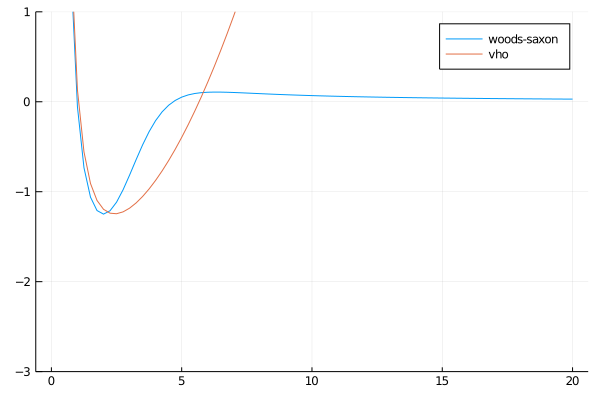

In [7]:
test_initial_potential(pars, rs; q=-1, l=1)

In [8]:
function trapezoidal_rule(rs, f)
    h = rs[2] - rs[1]
    sum(f[2:end])*h
end

function solve_scheq(pars, rs, vpot, emc², E, qnums)
    mc² = pars.mc²
    ħc = pars.ħc
    
    l = qnums.l
    
    k² = zeros(Float64, length(rs))
    @. k² = -vpot + E*2emc²/ħc^2
    
    S = zeros(Float64, length(rs))
    
    # matching point
    h = rs[2] - rs[1]
    irc = floor(Int, pars.R/h)
    
    # outward integration
    u₁ = zeros(Float64, length(rs))
    u₁[2] = rs[2]^(l+1)
    if l==1
        u₁[3] = 2(1 - (5h^2/12)*k²[2])*u₁[2] + (h^2/12)*l*(l+1)
        u₁[3] /= 1 + (h^2/12)*k²[3]
    else
        u₁[3] = 2(1 - (5h^2/12)*k²[2])*u₁[2]
        u₁[3] /= 1 + (h^2/12)*k²[3]
    end
    for ir in 3:irc-1
        u₁[ir+1] = numerov(ir, rs, k², S, u₁[ir-1], u₁[ir])
    end
    
    # inward integration
    u₂ = zeros(Float64, length(rs))
    if k²[end] < 0
        κ = sqrt(-k²[end])
        @. u₂[end-1:end] = exp(-κ*rs[end-1:end])
    else
        k = sqrt(k²[end])
        @. u₂[end-1:end] = sin(k*(rs[end-1:end] - rs[end]))
    end
    for ir in length(rs)-1: -1: irc+1
        u₂[ir-1] = numerov(ir, rs, k², S, u₂[ir+1], u₂[ir]; sign=-1)
    end
    
    # normalize u₂ so that u₁[irc] = u₂[irc]
    @. u₂ *= u₁[irc]/u₂[irc]
    u = vcat(u₁[1:irc], u₂[irc+1:end])
    
    # normalize wave function
    norm = trapezoidal_rule(rs, @. emc²*u^2)
    u /= sqrt(norm)
    
    # calculate discontinuity at matching point
    discontinuity = (u[irc-1] + u[irc+1] - (2 - h^2*k²[irc])*u[irc])/h
    
    @. u = sqrt(emc²)*u
    
    return u, discontinuity
end

function calc_discontinuity(E, pars, rs, vpot, emc², qnums)
    u, discontinuity = solve_scheq(pars, rs, vpot, emc², E, qnums)
    return discontinuity
end

function test_solve_scheq(pars, rs, qnums; E=-25)
    vinit = initial_potential(pars, rs, qnums)
    vho = calc_vho(pars, rs, qnums)
    emc² = initial_emc²(pars, rs)
    
    @time E = bisect(calc_discontinuity, -20, -10, args=(pars, rs, vho, emc², qnums))
    @time u, discontinuity = solve_scheq(pars, rs, vho, emc², E, qnums)
    
    @show E discontinuity trapezoidal_rule(rs, u.^2)
    plot(rs, (@. u/rs^(qnums.l + 1)), xlims=(0,6))
end
    

test_solve_scheq (generic function with 1 method)

  0.066036 seconds (37.15 k allocations: 2.271 MiB)
  0.000009 seconds (11 allocations: 6.609 KiB)
E = -15.006477237911895
discontinuity = -2.668615328715873e-12
trapezoidal_rule(rs, u .^ 2) = 1.0


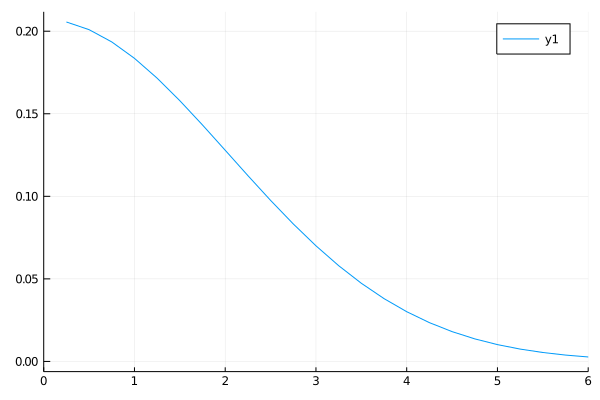

In [9]:
qnums = My.QuantumNumbers(l=1,j=1,q=1)
rs = range(0, 20, length=80+1)
test_solve_scheq(pars, rs, qnums) 

In [10]:
function shooting(pars, rs, vpot, emc², Es, qnums)
    states = My.SingleParticleState[]
    
    for i in 1:length(Es)-1
        d₁ = calc_discontinuity(Es[i], pars, rs, vpot, emc², qnums)
        d₂ = calc_discontinuity(Es[i+1], pars, rs, vpot, emc², qnums)
        
        if d₁*d₂ < 0
            E = bisect(calc_discontinuity, Es[i], Es[i+1], args=(pars, rs, vpot, emc², qnums))
            if abs(calc_discontinuity(E, pars, rs, vpot, emc², qnums)) < 1e-5
                u, discontinuity = solve_scheq(pars, rs, vpot, emc², E, qnums)
                push!(states, My.SingleParticleState(E=E, qnums=qnums, u=u))
            end
        end
    end
    
    return states
end

"""
    sort_states(states)

Sort states::Array{SingleParticleStates, 1} such that states[i].E ≤ states[j].E for i < j
"""
function sort_states(states)
    n_states = length(states)
    for i in 1:n_states-1
        for j in i+1:n_states
            if states[i].E > states[j].E
                temp = states[i]
                states[i] = states[j]
                states[j] = temp
            end
        end
    end
    return states
end
    

"""
    show_states(states)

Show energy and quantum numbers of each s. p. states.
"""
function show_states(states)
    for i in 1:length(states)
        println("i = $i")
        @show states[i].E states[i].qnums
        println("")
    end
end

"""
    show_states(states, occ)

Show energy, quantum numbers and occupation number of each s. p. states.
"""
function show_states(states, occ)
    for i in 1:length(states)
        println("i = $i")
        @show states[i].E states[i].qnums occ[i]
        println("")
    end
end


function plot_states(rs, states; nstates=length(states), derivative=false)
    p = plot()
    for i in 1:nstates
        plot!(p, rs, states[i].u, label="i = $i")
    end
    if derivative
        for i in 1:nstates
            du = derivative_5p(rs, states[i].u; parity=(-1)^(states[i].qnums.l+1))
            plot!(p, rs, du, label="i = $i")
        end
    end
    return p
end
        

function test_shooting(pars, rs, qnums; derivative=false)
    vho = calc_vho(pars, rs, qnums)
    emc² = initial_emc²(pars, rs)
    
    Es = range(-40, 40, length=10)
    
    @time states = shooting(pars, rs, vho, emc², Es, qnums)
    show_states(states)
    plot_states(rs, states; derivative=derivative)
end

test_shooting (generic function with 1 method)

  0.029353 seconds (36.64 k allocations: 3.352 MiB)
i = 1
(states[i]).E = -15.006477237782544
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)

i = 2
(states[i]).E = 4.995245363356338
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)



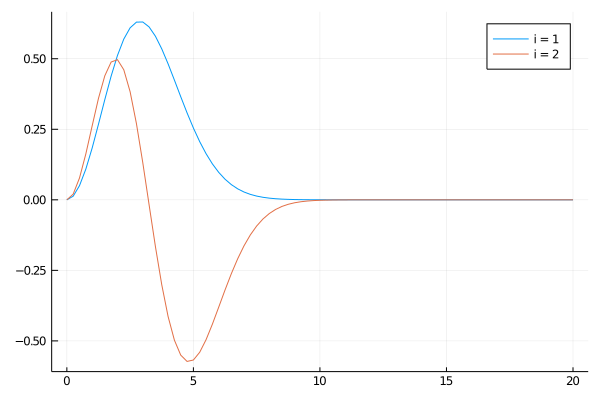

In [11]:
qnums = My.QuantumNumbers(l=1, j=1, q=1)
test_shooting(pars, rs, qnums; derivative=false)

In [12]:
function initial_states(pars, rs; lmax=10)
    Es = range(-50, -0, length=10)
    states = My.SingleParticleState[]
    emc² = initial_emc²(pars, rs)
    
    for l in 0:lmax,  j in 2l+1: -2: max(2l-1, 0),  q in 1: -2: -1
        qnums = My.QuantumNumbers(l=l, j=j, q=q)
        vpot = initial_potential(pars, rs, qnums)
        
        states = vcat(states, shooting(pars, rs, vpot, emc², Es, qnums))
    end
    
    return sort_states(states)
end

"""
    calc_occ(pars, states)

calculate occupation number .
"""
function calc_occ(pars, states)
    Z = pars.Z
    N = pars.N
    occ = zeros(Float64, length(states))
    
    # calculate occupation number 
    n_prot = 0
    n_neut = 0
    for i in 1:length(states)
        j = states[i].qnums.j
        q = states[i].qnums.q
        if q == 1 # neutron
            if n_neut + (j+1) ≤ N
                occ[i] = 1
                n_neut += (j+1)
            elseif n_neut < N
                occ[i] = (N - n_neut)/(j+1)
                n_neut = N
            end
        elseif q == -1 # proton
            if n_prot + (j+1) ≤ Z
                occ[i] = 1
                n_prot += (j+1)
            elseif n_prot < Z
                occ[i] = (Z - n_prot)/(j+1)
                n_prot = Z
            end
        end
    end
    @assert n_prot == Z && n_neut == N
    
    return occ
end

function test_initial_states(pars, rs; derivative=false)
    @time states = initial_states(pars, rs)
    occ = calc_occ(pars, states)
    show_states(states, occ)
    plot_states(rs, states; derivative=derivative)
end

test_initial_states (generic function with 1 method)

  0.017424 seconds (59.92 k allocations: 26.803 MiB)
i = 1
(states[i]).E = -39.95301635780681
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 2
(states[i]).E = -36.10955011358277
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)
occ[i] = 1.0

i = 3
(states[i]).E = -35.74185183323506
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 1.0

i = 4
(states[i]).E = -32.59171263780444
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -1)
occ[i] = 1.0

i = 5
(states[i]).E = -31.579482956375514
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, 1)
occ[i] = 1.0

i = 6
(states[i]).E = -30.669431098633353
(states[i]).qnums = Main.My.QuantumNumbers(2, 3, 1)
occ[i] = 1.0

i = 7
(states[i]).E = -29.45924362995559
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 8
(states[i]).E = -29.306018606035245
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, -1)
occ[i] = 1.0

i = 9
(states[i]).E = -28.77201240820189
(states[i]).qnums = Main.My.QuantumNumbers(1,

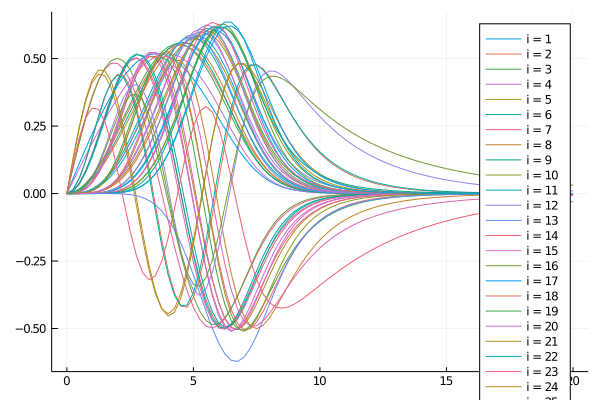

In [13]:
pars = make_pars(82, 126; version=:SIII)
test_initial_states(pars, rs)

In [14]:
function calc_density(pars, rs, states, occ)
    ngrids = length(rs)
    nstates = length(states)
    
    temp = zeros(Float64, ngrids)
    ρq = zeros(Float64, ngrids, 2)
    τq = zeros(Float64, ngrids, 2)
    Jq = zeros(Float64, ngrids, 2)
    
    for i in 1:nstates
        l = states[i].qnums.l
        j = states[i].qnums.j
        q = states[i].qnums.q
        iq = q_to_iq(q)
        
        u = states[i].u
        du = derivative_5p(rs, u; parity=(-1)^(l+1), order=1)
        
        # number density
        @. temp = occ[i] * (j+1)/4π * (u/rs)^2
        if l==0
            temp[1] = 4temp[2] - 6temp[3] + 4temp[4] - temp[5]
        else
            temp[1] = 0
        end
        @. ρq[:, iq] += temp
        
        # kinetic density
        @. temp = occ[i] * (j+1)/4π * ( (du/rs - u/rs^2)^2 + l*(l+1)*(u/rs^2)^2 )
        if l==0 
            temp[1] = 0
        elseif l==1
            temp[1] = 4temp[2] - 6temp[3] + 4temp[4] - temp[5]
        else
            temp[1] = 0
        end
        @. τq[:, iq] += temp
        
        # spin-orbit current
        ls = (j*(j+2) - 4l*(l+1) - 3)/8
        @. temp = occ[i] * (j+1)/2π * ls/rs * (u/rs)^2
        temp[1] = 0 
        @. Jq[:, iq] += temp
    end
    
    # coulomb potential
    ϕ = solve_poisson(pars.Z, rs, ρq[:, 2])
    
    dens = My.Densities(ρq=ρq, τq=τq, Jq=Jq, ϕ=ϕ)
    return dens
end

function plot_density(rs, dens; xlims=(0,20), density=:ρ)
    p = plot(xlims=xlims)
    
    if density==:ρ
        plot!(p, rs, dens.ρq[:, 1], label="ρn")
        plot!(p, rs, dens.ρq[:, 2], label="ρp")
        
        dρq = derivative_5p(rs, dens.ρq; parity=1, order=1)
        plot!(p, rs, dρq[:, 1], label="dρn")
        plot!(p, rs, dρq[:, 2], label="dρp")
        
        d²ρq = derivative_5p(rs, dens.ρq; parity=1, order=2)
        plot!(p, rs, d²ρq[:, 1], label="d²ρn")
        plot!(p, rs, d²ρq[:, 2], label="d²ρp")
    end
    
    if density==:τ
        plot!(p, rs, dens.τq[:, 1], label="τn")
        plot!(p, rs, dens.τq[:, 2], label="τp")
    end
    
    if density==:J
        plot!(p, rs, dens.Jq[:, 1], label="Jn")
        plot!(p, rs, dens.Jq[:, 2], label="Jp")
        
        dJq = derivative_5p(rs, dens.Jq; parity=-1, order=1)
        plot!(p, rs, dJ[:, 1], label="dJn")
        plot!(p, rs, dJ[:, 2], label="dJp")
    end
    
    if density==:ϕ
        plot!(p, rs, dens.ϕ, label="ϕ")
    end
    
    return p
end

function test_calc_density(pars, rs; density=:ρ, xlims=(0,10))
    @time states = initial_states(pars, rs)
    show_states(states)
    occ = calc_occ(pars, states)
    
    @time dens = calc_density(pars, rs, states, occ)
    plot_density(rs, dens; density=density, xlims=xlims)
end

test_calc_density (generic function with 1 method)

  0.006102 seconds (19.26 k allocations: 9.528 MiB)
i = 1
(states[i]).E = -31.07223601028737
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 2
(states[i]).E = -27.020027793736922
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -1)

i = 3
(states[i]).E = -18.597374633989403
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)

i = 4
(states[i]).E = -14.975635750064004
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, -1)

i = 5
(states[i]).E = -13.446401820207635
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)

i = 6
(states[i]).E = -9.844461199180737
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, -1)

i = 7
(states[i]).E = -6.350060078612942
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, 1)

i = 8
(states[i]).E = -3.977410766593594
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 9
(states[i]).E = -3.1980967816909662
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, -1)

i = 10
(states[i]).E = -1.1589444697569384
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -

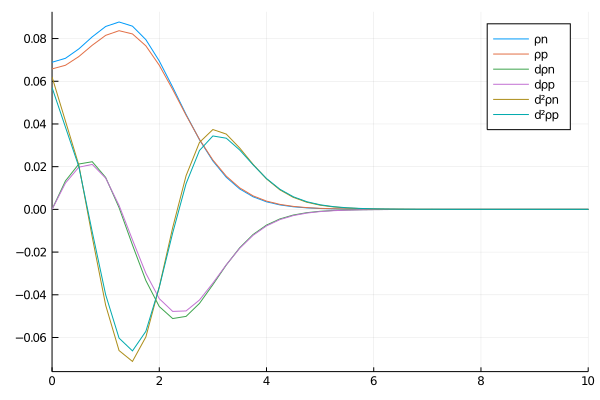

In [15]:
pars = make_pars(8, 8; version=:SIII)
rs = range(0, 20, length=80+1)
test_calc_density(pars, rs; density=:ρ)

In [16]:
function calc_emc²(pars, rs, dens, q)
    ħc = pars.ħc
    mc² = pars.mc²
    
    t₁ = pars.t₁
    t₂ = pars.t₂
    x₁ = pars.x₁
    x₂ = pars.x₂
    
    iq = q_to_iq(q)
    
    ρq = dens.ρq
    
    ρ = zeros(Float64, length(rs))
    @. ρ = ρq[:, 1] + ρq[:, 2]
    
    emc² = zeros(Float64, length(rs))
    @. emc² = ħc^2/2mc² 
    @. emc² += (t₁/4)*((1 + x₁/2)*ρ - (x₁ + 1/2)*ρq[:, iq]) 
    @. emc² += (t₂/4)*((1 + x₂/2)*ρ + (x₂ + 1/2)*ρq[:, iq])
    
    @. emc² = (1/emc²)*(ħc^2/2)
    
    return emc²
end

function test_calc_emc²(pars, rs, qnums)
    states = initial_states(pars, rs)
    occ = calc_occ(pars, states)
    
    dens = calc_density(pars, rs, states, occ)
    
    emc² = calc_emc²(pars, rs, dens, qnums.q)
    plot(rs, emc², label="emc²")
end
    

test_calc_emc² (generic function with 1 method)

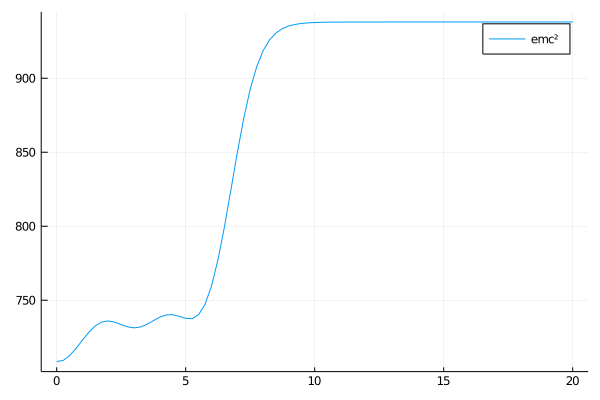

In [17]:
pars = make_pars(82, 126; version=:SIII)
qnums = My.QuantumNumbers(l=0, j=1, q=1)
test_calc_emc²(pars, rs, qnums)

In [18]:
function HF_potential(pars, rs, dens, emc², qnums)
    ħc = pars.ħc
    α = pars.α  
    
    t₀ = pars.t₀
    t₁ = pars.t₁
    t₂ = pars.t₂
    t₃ = pars.t₃
    x₀ = pars.x₀
    x₁ = pars.x₁
    x₂ = pars.x₂
    x₃ = pars.x₃
    γ = pars.γ
    W₀ = pars.W₀
    
    ρq = dens.ρq
    τq = dens.τq
    Jq = dens.Jq
    ϕ = dens.ϕ
    
    dρq = derivative_5p(rs, ρq; parity=1, order=1)
    d²ρq = derivative_5p(rs, ρq; parity=1, order=2)
    dJq = derivative_5p(rs, Jq; parity=-1, order=1)
    
    l = qnums.l
    j = qnums.j
    q = qnums.q
    iq = q_to_iq(q)
    ls = (j*(j+2) - 4l*(l+1) - 3)/8
    
    vpot = zeros(Float64, length(rs))
    
    # t₀ term
    @. vpot += t₀*((1 + x₀/2)*(ρq[:, 1] + ρq[:, 2]) - (x₀ + 1/2)*ρq[:, iq])
    
    # t₁ term
    @. vpot += (t₁/4)*(1 + x₁/2)*(τq[:, 1] + τq[:, 2] - (3/2)*(d²ρq[:, 1] + d²ρq[:, 2]))
    @. vpot += -(t₁/4)*(x₁ + 1/2)*(τq[:, iq] - (3/2)*d²ρq[:, iq])
    
    # t₂ term
    @. vpot += (t₂/4)*(1 + x₂/2)*(τq[:, 1] + τq[:, 2] + (1/2)*(d²ρq[:, 1] + d²ρq[:, 2]))
    @. vpot += (t₂/4)*(x₂ + 1/2)*(τq[:, iq] + (1/2)*d²ρq[:, iq])
        
    # t₃ term
    @. vpot += (t₃/12)*(1 + x₃/2)*(2 + γ)*(ρq[:, 1] + ρq[:, 2])^(γ+1)
    @. vpot += -(t₃/12)*(x₃ + 1/2)*γ*(ρq[:, 1] + ρq[:, 2])^(γ-1)*(ρq[:, 1]^2 + ρq[:, 2]^2)
    @. vpot += -(t₃/12)*(x₃ + 1/2)*2(ρq[:, 1] + ρq[:, 2])^γ*ρq[:, iq]
    
    # W₀ term
    @. vpot += -(W₀/2)*(dJq[:, 1] + dJq[:, 2] + dJq[:, iq])
    @. vpot += (ls/rs)*W₀*(dρq[:, 1] + dρq[:, 2] + dρq[:, iq])
    
    # J² term
    if pars.J²
        @. vpot += -(ls/rs)*(1/8)*(t₁*x₁ + t₂*x₂)*(Jq[:, 1] + Jq[:, 2])
        @. vpot += (ls/rs)*(1/8)*(t₁ - t₂)*Jq[:, iq]
    end
    
    # Coulomb term
    if q==-1
        @. vpot += (ħc*α)*(ϕ - (3/π*ρq[:, 2])^(1/3) )
    end
    
    # normalization
    @. vpot *= 2emc²/ħc^2
    
    # effective mass term
    demc² = derivative_5p(rs, emc²; parity=1, order=1)
    d²emc² = derivative_5p(rs, emc²; parity=1, order=2)
    @. vpot += (5/4)*(demc²/emc²)^2 - (d²emc²/emc²)
    
    # centrifugal potential
    @. vpot += l*(l+1)/rs^2
    
    return vpot
end
    

function test_calc_potential(pars, rs, qnums)
    @time states = initial_states(pars, rs)
    occ = calc_occ(pars, states)
    
    @time dens = calc_density(pars, rs, states, occ)
    
    emc² = calc_emc²(pars, rs, dens, qnums.q)
    
    vpot_init = initial_potential(pars, rs, qnums)
    vpot_hf = HF_potential(pars, rs, dens, emc², qnums)
    plot(rs, vpot_hf, xlims=(0,20); label="hf")
    plot!(rs, vpot_init; label="init")
end

test_calc_potential (generic function with 1 method)

  0.044399 seconds (59.92 k allocations: 26.803 MiB, 65.87% gc time)
  0.001646 seconds (57.95 k allocations: 2.786 MiB)


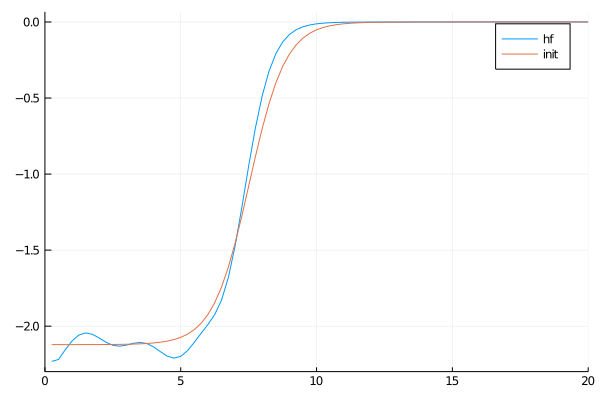

In [19]:
pars = make_pars(82, 126; version=:SIII)
qnums = My.QuantumNumbers(l=0,j=1,q=1)
rs = range(0, 20, length=80+1)
test_calc_potential(pars, rs, qnums)

In [20]:
function calc_energy(pars, rs, dens)
    ngrids = length(rs)
    
    ħc = pars.ħc
    mc² = pars.mc²
    α = pars.α  
    
    t₀ = pars.t₀
    t₁ = pars.t₁
    t₂ = pars.t₂
    t₃ = pars.t₃
    x₀ = pars.x₀
    x₁ = pars.x₁
    x₂ = pars.x₂
    x₃ = pars.x₃
    γ = pars.γ
    W₀ = pars.W₀
    
    ρq = dens.ρq
    τq = dens.τq
    Jq = dens.Jq
    ϕ = dens.ϕ
    
    dρq = derivative_5p(rs, ρq; parity=1, order=1)
    dJq = derivative_5p(rs, Jq; parity=-1, order=1)
    
    ρ = zeros(Float64, ngrids)
    @. ρ = ρq[:, 1] + ρq[:, 2]
    
    dρ = zeros(Float64, ngrids)
    @. dρ = dρq[:, 1] + dρq[:, 2]
    
    τ = zeros(Float64, ngrids)
    @. τ = τq[:, 1] + τq[:, 2]
    
    J = zeros(Float64, ngrids)
    @. J = Jq[:, 1] + Jq[:, 2]
    
    # energy density
    ε = zeros(Float64, ngrids)
    
    # kinetic term
    @. ε += (ħc^2/2mc²)*τ*(1 - 1/pars.A)
    
    # t₀ term
    @. ε += (t₀/2)*(1 + x₀/2)*ρ^2
    @. ε += -(t₀/2)*(x₀ + 1/2)*(ρq[:, 1]^2 + ρq[:, 2]^2)
    
    # t₁ term
    @. ε += (t₁/4)*(1 + x₁/2)*(ρ*τ + (3/4)*dρ^2)
    for iq in 1:2
        @. ε += -(t₁/4)*(x₁ + 1/2)*(ρq[:, iq]*τq[:, iq] + (3/4)*dρq[:, iq]^2)
    end
    
    # t₂ term
    @. ε += (t₂/4)*(1 + x₂/2)*(ρ*τ - (1/4)*dρ^2)
    for iq in 1:2
        @. ε += (t₂/4)*(x₂ + 1/2)*(ρq[:, iq]*τq[:, iq] - (1/4)*dρq[:, iq]^2)
    end
    
    # J² term
    if pars.J²
        @. ε += -(1/16)*(t₁*x₁ + t₂*x₂)*J^2
        @. ε += (1/16)*(t₁ - t₂)*(Jq[:, 1]^2 + Jq[:, 2]^2)
    end
    
    # t₃ term
    @. ε += (t₃/12)*(ρ^γ)*(1 + x₃/2)*ρ^2
    @. ε += -(t₃/12)*(ρ^γ)*(x₃ + 1/2)*(ρq[:, 1]^2 + ρq[:, 2]^2)
    
    # W₀ term
    @. ε += (W₀/2)*(J*dρ + Jq[:, 1]*dρq[:, 1] + Jq[:, 2]*dρq[:, 2])
    
    # coulomb term
    @. ε += (ħc*α/2)*ρq[:, 2]*ϕ
    @. ε += -(3ħc*α/4)*(3/π)^(1/3)*ρq[:, 2]^(4/3)
    
    E = trapezoidal_rule(rs, (@. 4π*rs^2*ε))
    return E
end

    


function calc_skin(pars, rs, dens)
    rn = sqrt(trapezoidal_rule(rs, (@. 4π*rs^4*dens.ρq[:, 1]))/pars.N)
    rp = sqrt(trapezoidal_rule(rs, (@. 4π*rs^4*dens.ρq[:, 2]))/pars.Z)
    return rn - rp
end
    
    

function HF_states(pars, rs, dens; lmax=10)
    Es = range(-50, 0, length=10)
    states = My.SingleParticleState[]
    
    for l in 0:lmax, j in 2l+1: -2: max(2l-1, 0), q in 1: -2: -1
        qnums = My.QuantumNumbers(l=l, j=j, q=q)
        emc² = calc_emc²(pars, rs, dens, qnums.q)
        vpot = HF_potential(pars, rs, dens, emc², qnums)
        
        states = vcat(states, shooting(pars, rs, vpot, emc², Es, qnums))
    end
    
    return sort_states(states)
end


function average_density!(d₁, d₂)
    @. d₁.ρq = (d₁.ρq + d₂.ρq)/2
    @. d₁.τq = (d₁.τq + d₂.τq)/2
    @. d₁.Jq = (d₁.Jq + d₂.Jq)/2
    @. d₁.ϕ = (d₁.ϕ + d₂.ϕ)/2
end

    
function HF_calc(pars, rs; lmax=10, iter_max=100, rtol=1e-5)
    states = initial_states(pars, rs; lmax=lmax)
    occ = calc_occ(pars, states)
    dens = calc_density(pars, rs, states, occ)
    energy = Float64[]
    
    for iter in 1:iter_max
        states = HF_states(pars, rs, dens; lmax=lmax)
        occ = calc_occ(pars, states)
        average_density!(dens, calc_density(pars, rs, states, occ))
        push!(energy, calc_energy(pars, rs, dens)/pars.A)
        if iter ≥ 2 && abs((energy[end-1] - energy[end])/energy[end]) < rtol
            return states, occ, dens, energy
        end
    end
    
    println("no convergence!")
    return states, occ, dens, energy
end

HF_calc (generic function with 1 method)

  0.528587 seconds (5.34 M allocations: 739.786 MiB, 16.44% gc time)
energy[end] = -8.547371928211136
calc_skin(pars, rs, dens) = 0.16091081275607788
i = 1
(states[i]).E = -47.96421025983162
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)
occ[i] = 1.0

i = 2
(states[i]).E = -47.49171419017431
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 1.0

i = 3
(states[i]).E = -44.020768042860766
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -1)
occ[i] = 1.0

i = 4
(states[i]).E = -42.09909883534742
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, 1)
occ[i] = 1.0

i = 5
(states[i]).E = -40.79376218271337
(states[i]).qnums = Main.My.QuantumNumbers(2, 3, 1)
occ[i] = 1.0

i = 6
(states[i]).E = -39.56766342744231
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, -1)
occ[i] = 1.0

i = 7
(states[i]).E = -39.044381934218116
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, -1)
occ[i] = 1.0

i = 8
(states[i]).E = -38.64549157830575
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ

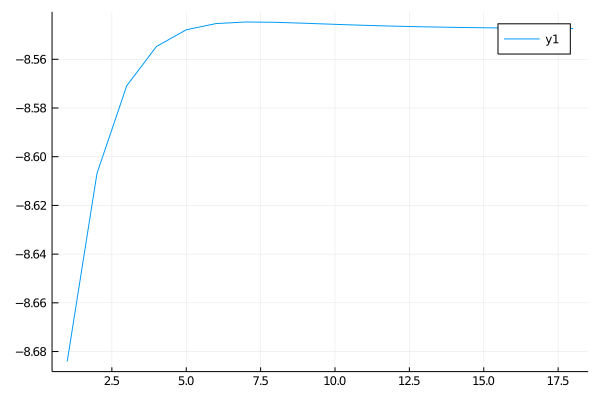

In [34]:
pars = make_pars(82, 126; version=:SkM, κ=1 + 0.01)
rs = range(0, 20, length=80+1)

@time states, occ, dens, energy = HF_calc(pars, rs)
@show energy[end] calc_skin(pars, rs, dens)
show_states(states, occ)
plot(energy)

# Continuum RPA calc.

### Radial Green's function
$$
\langle r | \frac{1}{\hat{h} - \varepsilon - i\eta} | r' \rangle
= \frac{u_{1}(r_{<}) u_{2}(r_{>})}{W}
$$
ただし、
$$
u_{1}(r) = r^{l+1}\ \ \ (r \to 0),\ \ \ 
u_{2}(r) = \exp(ikr)\ \ \ (r \to \infty)
\\
k = \sqrt{\frac{2m}{\hbar^2}(\varepsilon + i\eta)},\ \ \ 
W = \frac{\hbar^2}{2m} (u_{1}' u_{2} - u_{2}' u_{1})
$$

In [35]:
function calc_radial_green_function(pars, rs, vpot, emc², ε, qnums; iw=div(length(rs), 2))
    @assert imag(ε) ≥ 0
    
    mc² = pars.mc²
    ħc = pars.ħc
    
    ngrids = length(rs)
    h = rs[2] - rs[1]
    
    l = qnums.l
    
    k² = zeros(Complex{Float64}, ngrids)
    @. k² = -vpot + ε*2emc²/ħc^2 # ここ！
    
    S = zeros(Float64, ngrids)
    
    # outward integration
    u₁ = zeros(Complex{Float64}, ngrids)
    u₁[2] = rs[2]^(l+1)
    if l==1
        u₁[3] = 2(1 - (5h^2/12)*k²[2])*u₁[2] + (h^2/12)*l*(l+1)
        u₁[3] /= 1 + (h^2/12)*k²[3]
    else
        u₁[3] = 2(1 - (5h^2/12)*k²[2])*u₁[2]
        u₁[3] /= 1 + (h^2/12)*k²[3]
    end
    for ir in 3:ngrids-1
        u₁[ir+1] = numerov(ir, rs, k², S, u₁[ir-1], u₁[ir])
    end
    
    # inward integration
    u₂ = zeros(Complex{Float64}, ngrids)
    k = sqrt(k²[end])
    @. u₂[end-1:end] = exp(im*k*rs[end-1:end])
    for ir in ngrids-1: -1: 3
        u₂[ir-1] = numerov(ir, rs, k², S, u₂[ir+1], u₂[ir]; sign=-1)
    end
    u₂[1] = 4u₂[2] - 6u₂[3] + 4u₂[4] - u₂[5]
    
    # calculate Wronskian
    du₁ = (-(1/12)*u₁[iw+2] + (2/3)*u₁[iw+1] - (2/3)*u₁[iw-1] + (1/12)*u₁[iw-2])/h
    du₂ = (-(1/12)*u₂[iw+2] + (2/3)*u₂[iw+1] - (2/3)*u₂[iw-1] + (1/12)*u₂[iw-2])/h
    wronskian = (ħc^2/2mc²)*(du₁*u₂[iw] - du₂*u₁[iw]) 
    #@show wronskian  iw
    
    # calculate radial green function 
    green_function = zeros(Complex{Float64}, ngrids, ngrids)
    for jr in 1:ngrids,  ir in 1:jr
        green_function[ir, jr] = u₁[ir]*u₂[jr]/wronskian * sqrt(emc²[ir]/emc²[jr]) #ここ！
    end
    
    return Symmetric(green_function)
end

function test_calc_radial_green_function(pars, rs, qnums; ω=-10, iw=div(length(rs), 2))
    vpot = initial_potential(pars, rs, qnums)
    emc² = initial_emc²(pars, rs)
    @time green_function = calc_radial_green_function(pars, rs, vpot, emc², ω, qnums; iw=iw)
end

test_calc_radial_green_function (generic function with 1 method)

In [36]:
qnums = My.QuantumNumbers(l=0, j=1, q=1)
test_calc_radial_green_function(pars, rs, qnums; ω=10)

  0.000098 seconds (7 allocations: 107.750 KiB)


81×81 Symmetric{Complex{Float64},Array{Complex{Float64},2}}:
  0.0+0.0im          0.0+0.0im          …          0.0+0.0im
  0.0+0.0im    0.0109948+0.0041897im       -0.00944383+0.0142008im
  0.0+0.0im   0.00849696+0.00770684im       -0.0173717+0.026122im
  0.0+0.0im   0.00463513+0.00998682im       -0.0225109+0.0338499im
  0.0+0.0im   2.92529e-5+0.0106637im        -0.0240365+0.036144im
  0.0+0.0im  -0.00458133+0.00962875im   …   -0.0217038+0.0326362im
 -0.0-0.0im  -0.00845652+0.00704823im       -0.0158871+0.0238896im
 -0.0-0.0im   -0.0109743+0.00333636im      -0.00752034+0.0113084im
 -0.0-0.0im   -0.0117307-0.000911027im      0.00205351-0.00308788im
 -0.0-0.0im   -0.0106043-0.0050122im         0.0112978-0.0169886im
 -0.0-0.0im   -0.0077761-0.00830903im   …     0.018729-0.0281631im
  0.0-0.0im  -0.00370017-0.0102726im         0.0231551-0.0348185im
  0.0-0.0im  0.000969396-0.0105882im         0.0238664-0.0358883im
     ⋮                                  ⋱             ⋮
  0.0+0.0im      0.

### free response function
$$
    \Pi_{0}^{(q)}(i, k; \omega)
    = - \sum_{h} \sum_{lj} \phi_{hq}(r_{i}) \phi_{hq}(r_{j})
    \langle lj \| Y_{L} \| l_{h} j_{h} \rangle^2 \frac{1}{2L+1}
    \\
    \times \langle r_{i} | 
    \frac{1}{\hat{h}_{ljq} - \varepsilon_{hq} \mp \hbar\omega - i\eta} 
    | r_{j} \rangle
$$
ただし、
$$
    \frac{1}{\hat{h}_{ljq} - \varepsilon_{hq} \mp \hbar\omega - i\eta} 
    := \frac{1}{\hat{h}_{ljq} - \varepsilon_{hq} - \hbar\omega - i\eta} 
    + \frac{1}{\hat{h}_{ljq} - \varepsilon_{hq} + \hbar\omega - i\eta} 
$$

In [37]:
function calc_reduced_matrix_element(l₂, j₂, λ, l, j)
    if isodd(l + l₂ + λ)
        return 0.0
    end
    
    M = (-1)^div(j₂+1,2)*sqrt((j+1)*(j₂+1)*(2λ+1)/4π)*wigner3j(j₂, 2λ, j, 1, 0, -1)
    return M
end



function calc_free_response_function(pars, rs, states, occ, dens, ω, L; lmax=10, η=0, hf=false)
    ngrids = length(rs)
    nstates = length(states)
    
    Π₀ = zeros(Complex{Float64}, ngrids, ngrids, 2)
    vpot = zeros(Float64, ngrids)
    for istate in 1:nstates
        if occ[istate]==1.0
            ϕ₁ = states[istate].u
            ε₁ = states[istate].E
            l₁ = states[istate].qnums.l
            j₁ = states[istate].qnums.j
            q = states[istate].qnums.q
            iq = div(3-q, 2)
            
            for l in 0:lmax,  j in 2l+1: -2: max(2l-1, 0)
                qnums = My.QuantumNumbers(l=l, j=j, q=q)
                rme = calc_reduced_matrix_element(l, j, L, l₁, j₁)
                
                if abs(rme) > 1e-10
                    #=
                    if hf==true
                        vpot = hartree_fock_potential(pars, rs, dens, qnums)
                    else
                        vpot = initial_potential(pars, rs, qnums)
                    end
                    =#
                    emc² = calc_emc²(pars, rs, dens, qnums.q)
                    vpot = HF_potential(pars, rs, dens, emc², qnums)
                    
                    G₁ = calc_radial_green_function(pars, rs, vpot, emc², ε₁+ω+im*η, qnums)
                    G₂ = calc_radial_green_function(pars, rs, vpot, emc², ε₁-ω+im*η, qnums)
                    
                    temp = rme^2/(2L+1)
                    for jr in 1:ngrids,  ir in 1:jr
                        Π₀[ir, jr, iq] += -ϕ₁[ir]*ϕ₁[jr]*temp*(G₁[ir, jr] + G₂[ir, jr])
                    end
                end
            end
            
            # hole-hole contribtion. If η=0, this contribution becoms 0.
            for jstate in 1:nstates
                l₂ = states[jstate].qnums.l
                j₂ = states[jstate].qnums.j
                rme = calc_reduced_matrix_element(l₂, j₂, L, l₁, j₁)
                
                if occ[jstate]==1.0 && states[jstate].qnums.q==q && abs(rme) > 1e-10
                    ϕ₂ = states[jstate].u
                    ε₂ = states[jstate].E
                    
                    temp = rme^2/(2L+1)*(1/(ε₂ - ε₁ - ω - im*η) + 1/(ε₂ - ε₁ + ω - im*η))
                    for jr in 1:ngrids,  ir in 1:jr
                        Π₀[ir, jr, iq] += ϕ₁[ir]*ϕ₁[jr]*ϕ₂[ir]*ϕ₂[jr]*temp
                    end
                end
            end
            
        end
    end
    
    for iq in 1:2,  jr in 1:ngrids,  ir in 1:jr
        Π₀[jr, ir, iq] = Π₀[ir, jr, iq]
    end
    
    return Π₀
end

function test_calc_free_response_function(pars, rs, ω, L)
    states = initial_states(pars, rs)
    occ = calc_occ(pars, states)
    dens = calc_density(pars, rs, states, occ)
    
    @time free_response = calc_free_response_function(pars, rs, states, occ, dens, ω, L)
end

test_calc_free_response_function (generic function with 1 method)

In [38]:
test_calc_free_response_function(pars, rs, 30, 1)

  0.057169 seconds (411.94 k allocations: 43.724 MiB, 17.95% gc time)


81×81×2 Array{Complex{Float64},3}:
[:, :, 1] =
 0.0+0.0im          0.0+0.0im         …           0.0+0.0im
 0.0+0.0im  -4.39816e-5-5.88817e-7im      -1.81993e-9-9.77408e-9im
 0.0+0.0im  -4.35978e-5-4.1927e-6im       -1.05706e-8-6.2057e-8im
 0.0+0.0im  -3.88756e-5-1.16148e-5im      -1.70916e-8-1.32929e-7im
 0.0+0.0im   -2.2854e-5-2.06997e-5im        4.9804e-9-1.21651e-7im
 0.0+0.0im   4.73127e-6-2.74426e-5im  …    8.22622e-8+8.92346e-8im
 0.0+0.0im   3.90631e-5-2.81619e-5im       2.18189e-7+5.40992e-7im
 0.0+0.0im   7.18926e-5-2.15138e-5im       3.81296e-7+1.1371e-6im
 0.0+0.0im   9.43717e-5-9.39577e-6im       5.17643e-7+1.66387e-6im
 0.0+0.0im  0.000100229+3.68188e-6im       5.84167e-7+1.89704e-6im
 0.0+0.0im   8.82219e-5+1.25777e-5im  …    5.82874e-7+1.73937e-6im
 0.0+0.0im   6.27578e-5+1.39982e-5im       5.70138e-7+1.30181e-6im
 0.0+0.0im   3.21479e-5+8.17365e-6im       6.28428e-7+8.64846e-7im
    ⋮                                 ⋱              ⋮
 0.0+0.0im  -6.93755e-9+5.00035e-8im

### Residual Interaction
$$
\bar{v}_{qq'}
= t_{0}\left[
  \left(1 + \frac{x_{0}}{2}\right)
  - \left(x_{0} + \frac{1}{2}\right) \delta_{qq'}
\right]
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
\\
+ \frac{t_{3}}{12} \left[
  \left(1 + \frac{x_{3}}{2}\right) (\gamma + 2) (\gamma + 1) \rho^{\gamma}
  \\
  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
  - \left(x_{3} + \frac{1}{2}\right) \left\{
    \gamma(\gamma-1)\rho^{\gamma-2} \sum_{q} \rho_{q}^{2}
    \\
    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
    + 2\gamma \rho^{\gamma-1} (\rho_{q} + \rho_{q'})
    + 2\rho^{\gamma} \delta_{qq'}
  \right\}
\right]
$$

In [48]:
function calc_residual_interaction(pars, rs, dens; κ=1)
    ngrids = length(rs)
    
    t₀ = pars.t₀
    t₃ = pars.t₃
    x₀ = pars.x₀
    x₃ = pars.x₃
    γ = pars.γ
    
    χ = zeros(Float64, ngrids, 2, 2)
    
    ρq = dens.ρq
    
    ρ = zeros(Float64, ngrids)
    @. ρ = ρq[:, 1] + ρq[:, 2]
    
    for iq₁ in 1: 2,  iq₂ in 1: 2
    
        # t₀ term
        @. χ[:, iq₁, iq₂] += t₀*((1 + x₀/2) - (x₀ + 1/2)*(iq₁==iq₂))

        # t₃ term
        @. χ[:, iq₁, iq₂] += 
            (t₃/12)*(1 + x₃/2)*(γ+2)*(γ+1)*ρ^γ 
        if γ ≠ 1
            @. χ[:, iq₁, iq₂] += 
                -(t₃/12)*(x₃ + 1/2) * γ*(γ-1)*ρ^(γ-2)*(ρq[:, 1]^2 + ρq[:, 2]^2)
        end
        @. χ[:, iq₁, iq₂] += 
            -(t₃/12)*(x₃ + 1/2)*(2γ*ρ^(γ-1)*(ρq[:, iq₁] + ρq[:, iq₂]) + 2ρ^γ*(iq₁==iq₂))

        Δr = rs[2] - rs[1]
        @. χ[:, iq₁, iq₂] *= (Δr/rs^2) *κ
        χ[1, iq₁, iq₂] = 4χ[2, iq₁, iq₂] - 6χ[3, iq₁, iq₂] + 4χ[4, iq₁, iq₂] - χ[5, iq₁, iq₂]
        #χ[1, iq₁, iq₂] = 0
    end

    return χ
end

    
function test_calc_residual_interaction(pars, rs; κ=1, ylims=(-30, 30))
    states, occ, dens, energy = HF_calc(pars, rs)
    
    χ = calc_residual_interaction(pars, rs, dens; κ=κ)
    
    p = plot(ylims=ylims)
    plot!(p, rs, χ[:, 1, 1], label="χnn")
    plot!(p, rs, χ[:, 2, 1], label="χnp")
    plot!(p, rs, χ[:, 2, 2], label="χpp")
end

test_calc_residual_interaction (generic function with 1 method)

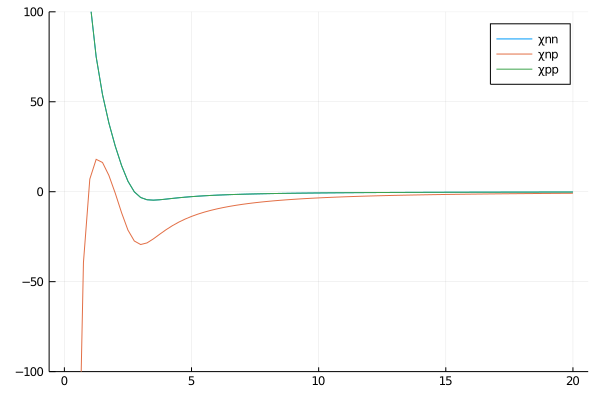

In [40]:
pars = make_pars(8, 8; version=:Simplified)
test_calc_residual_interaction(pars, rs; κ=1, ylims=(-100, 100))

### Dispersion relation
$$
\mathrm{det} \left(
  \begin{array}{cc}
    1 - \chi_{nn} \Pi_{0}^{(n)}(\omega) & -\chi_{np} \Pi_{0}^{(p)}(\omega)  \\
    -\chi_{pn}\Pi_{0}^{(n)}(\omega) & 1 - \chi_{pp} \Pi_{0}^{(p)}(\omega)
  \end{array}
\right) = 0
$$

In [41]:
function calc_dispersion_relation(pars, rs, Π₀, χ)
    ngrids = length(rs)
    
    χΠ₀ = zeros(Complex{Float64}, 2ngrids, 2ngrids)
    
    @views χΠ₀[1:ngrids, 1:ngrids] = Diagonal(χ[:,1,1])*Π₀[:,:,1]
    @views χΠ₀[1:ngrids, ngrids+1:2ngrids] = Diagonal(χ[:,1,2])*Π₀[:,:,2]
    @views χΠ₀[ngrids+1:2ngrids, 1:ngrids] = Diagonal(χ[:,2,1])*Π₀[:,:,1]
    @views χΠ₀[ngrids+1:2ngrids, ngrids+1:2ngrids] = Diagonal(χ[:,2,2])*Π₀[:,:,2]
    
    return det(I - χΠ₀)
end

function calc_dispersion_relation(pars, rs; 
        L=1, ωmin=0, ωmax=30, ωlength=300, κ=1, η=0)
    
    states, occ, dens, energy = HF_calc(pars, rs)
    
    χ = calc_residual_interaction(pars, rs, dens; κ=κ)
    
    ω = range(ωmin, ωmax, length=ωlength+1)
    dispersion = zeros(Float64, length(ω))
    for i in 1:length(ω)
        Π₀ = calc_free_response_function(pars, rs, states, occ, dens, ω[i], L; η=η)
        dispersion[i] = abs(calc_dispersion_relation(pars, rs, Π₀, χ))
    end
    
    return ω, dispersion
end

calc_dispersion_relation (generic function with 2 methods)

In [29]:
pars = make_pars(8, 8; version=:Simplified)
@time ω, dispersion = 
calc_dispersion_relation(pars, rs; κ=1, L=1, η=0, ωmin=0, ωmax=30)
;

  4.343290 seconds (22.38 M allocations: 2.690 GiB, 12.28% gc time)


dispersion[1] = 0.9360953056608784


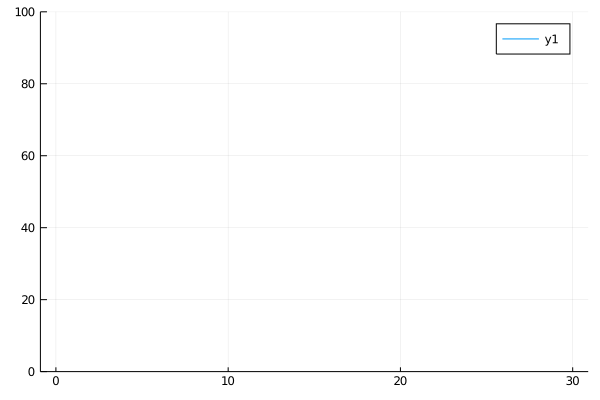

In [31]:
@show dispersion[1]
plot(ω[1:end], dispersion[1:end]; ylims=(0, 100))

### RPA response function
$$
\left(
  \begin{array}{cc}
    \Pi_{\mathrm{RPA}}^{(nn)} & \Pi_{\mathrm{RPA}}^{(np)} \\ 
    \Pi_{\mathrm{RPA}}^{(pn)} & \Pi_{\mathrm{RPA}}^{(pp)}
  \end{array}
\right) 
= \left(
  \begin{array}{cc}
    1 - \chi_{nn} \Pi_{0}^{(n)}(\omega) & -\chi_{np} \Pi_{0}^{(p)}(\omega)  \\
    -\chi_{pn}\Pi_{0}^{(n)}(\omega) & 1 - \chi_{pp} \Pi_{0}^{(p)}(\omega)
  \end{array}
\right)^{-1} 
\left(
  \begin{array}{cc}
    \Pi_{0}^{(n)} & 0 \\ 
    0 & \Pi_{0}^{(p)}
  \end{array}
\right) 
$$

In [42]:
function calc_rpa_response_function(pars, rs, Π₀, χ)
    ngrids = length(rs)
    Π₀χ = zeros(Complex{Float64}, 2ngrids, 2ngrids)
    
    @views Π₀χ[1:ngrids, 1:ngrids] = Π₀[:, :, 1]*Diagonal(χ[:, 1, 1])
    @views Π₀χ[1:ngrids, ngrids+1:2ngrids] = Π₀[:, :, 1]*Diagonal(χ[:, 1, 2])
    @views Π₀χ[ngrids+1:2ngrids, 1:ngrids] = Π₀[:, :, 2]*Diagonal(χ[:, 2, 1])
    @views Π₀χ[ngrids+1:2ngrids, ngrids+1:2ngrids] = Π₀[:, :, 2]*Diagonal(χ[:, 2, 2])
    
    M = (I - Π₀χ)\I
    
    Π_rpa = zeros(Complex{Float64}, 2ngrids, 2ngrids)
    @views Π_rpa[1:ngrids, 1:ngrids] = M[1:ngrids, 1:ngrids]*Π₀[:, :, 1]
    @views Π_rpa[1:ngrids, ngrids+1:2ngrids] = M[1:ngrids, ngrids+1:2ngrids]*Π₀[:, :, 2]
    @views Π_rpa[ngrids+1:2ngrids, 1:ngrids] = M[ngrids+1:2ngrids, 1:ngrids]*Π₀[:, :, 1]
    @views Π_rpa[ngrids+1:2ngrids, ngrids+1:2ngrids] = 
        M[ngrids+1:2ngrids, ngrids+1:2ngrids]*Π₀[:, :, 2]
    
    return Π_rpa
end

function test_calc_rpa_response_function(pars, rs, ω, L)
    states, occ, dens, energy = HF_calc(pars, rs)
    
    @time Π₀ = calc_free_response_function(pars, rs, states, occ, dens, ω, L)
    
    @time dens = calc_density(pars, rs, states, occ)
    @time χ = calc_residual_interaction(pars, rs, dens; κ=0.7067)
    
    @time Π_rpa = calc_rpa_response_function(pars, rs, Π₀, χ)
end

test_calc_rpa_response_function (generic function with 1 method)

In [43]:
test_calc_rpa_response_function(pars, rs, 10, 1)

  0.006484 seconds (56.00 k allocations: 6.118 MiB)
  0.000371 seconds (14.49 k allocations: 719.188 KiB)
  0.000071 seconds (84 allocations: 23.469 KiB)
  0.004732 seconds (48 allocations: 2.565 MiB)


162×162 Array{Complex{Float64},2}:
 0.0+0.0im          0.0+0.0im           0.0+0.0im  …           0.0+0.0im
 0.0+0.0im  -3.67166e-5+0.0im   -4.10019e-5+0.0im      8.70125e-18+0.0im
 0.0+0.0im  -4.10019e-5+0.0im  -0.000325175+0.0im      5.74317e-17+0.0im
 0.0+0.0im  -4.83823e-5+0.0im  -0.000369111+0.0im      1.38183e-16+0.0im
 0.0+0.0im  -4.93395e-5+0.0im  -0.000368004+0.0im      1.91269e-16+0.0im
 0.0+0.0im  -3.54045e-5+0.0im   -0.00026695+0.0im  …   1.35185e-16+0.0im
 0.0+0.0im   2.40814e-6+0.0im    -8.0897e-6+0.0im     -1.22127e-16+0.0im
 0.0+0.0im   7.60002e-5+0.0im   0.000486315+0.0im     -6.97401e-16+0.0im
 0.0+0.0im  0.000195678+0.0im    0.00128407+0.0im     -1.69314e-15+0.0im
 0.0+0.0im  0.000346132+0.0im     0.0022839+0.0im     -2.98662e-15+0.0im
 0.0+0.0im  0.000460209+0.0im     0.0030418+0.0im  …  -3.99032e-15+0.0im
 0.0+0.0im  0.000466648+0.0im    0.00308651+0.0im     -4.06359e-15+0.0im
 0.0+0.0im  0.000379217+0.0im    0.00250923+0.0im     -3.31054e-15+0.0im
    ⋮           

### Strength function
$$
S(\omega) = -\frac{\Delta r^{2}}{\pi} 
\mathrm{Im}\, \sum_{i, j}
V_{\mathrm{ext}}^{(q)}(r_{i}) \,
\Pi_{\mathrm{RPA}}^{(qq')}(i, j; \omega)\,
V_{\mathrm{ext}}^{(q')}(r_{j})
$$

In [45]:
function calc_external_field(rs ; L=1, mode=:IV)
    ngrids = length(rs)
    Vext = zeros(Float64, 2ngrids)
    
    if L==0
        @. Vext[1:ngrids] = rs^2
    elseif L > 0
        @. Vext[1:ngrids] = rs^L
    else
        error("L must be non-negative.")
    end
    
    if mode==:IS # Isoscalar
        Vext[ngrids+1:2ngrids] =  Vext[1:ngrids]
    elseif mode==:IV # Isovector
        Vext[ngrids+1:2ngrids] = -Vext[1:ngrids]
    end
        
    return Vext
end

function calc_dipole_field(pars, rs)
    ngrids = length(rs)
    Vext = zeros(Float64, 2ngrids)
    
    Vext[1:ngrids] = rs*(pars.Z/pars.A)
    Vext[ngrids+1:2ngrids] = -rs*(pars.N/pars.A)
    
    return Vext
end


function calc_strength_function(pars, rs, Π_rpa, Vext, ω, L; η=0)
    Δr = rs[2] - rs[1]
    S = -(Δr^2/π)*imag(Vext' * Π_rpa * Vext)
    return S
end

function continuum_RPA_calc(pars, rs; 
        L=1, ωmin=0, ωmax=30, ωlength=300, mode=:IV, η=0, κ=1)
    
    ngrids = length(rs)
    
    states, occ, dens, energy = HF_calc(pars, rs)
    @show calc_skin(pars, rs, dens)
    
    χ = calc_residual_interaction(pars, rs, dens; κ=κ)
    
    Vext = calc_external_field(rs ; L=L, mode=mode)
    if mode==:dipole
        Vext = calc_dipole_field(pars, rs)
    end
    
    ω = range(ωmin, ωmax, length=ωlength+1)
    strength_function = zeros(Float64, length(ω))
    Π₀ = zeros(Float64, ngrids, ngrids, 2)
    for i in 1:length(ω)
        Π₀ = calc_free_response_function(pars, rs, states, occ, dens, ω[i], L; η=η)
        Π_rpa = calc_rpa_response_function(pars, rs, Π₀, χ)
        strength_function[i] = 
            calc_strength_function(pars, rs, Π_rpa, Vext, ω[i], L; η=η)
    end
    
    return ω, strength_function
end


function lorentzian(ω, ω₀, η, height)
    height*(η/π)/((ω-ω₀)^2 + η^2)
end

#=
model(ω, p) = @. lorentzian(ω, p[1], p[2], p[3]) + 
    lorentzian(ω, p[4], p[5], p[6]) + lorentzian(ω, p[7], p[8], p[9])
=#

function model(ω, p)
    @assert length(p)%3==0
    S = zeros(Float64, length(ω))
    for i in 1:div(length(p), 3)
        @. S += lorentzian(ω, p[3i-2], p[3i-1], p[3i])
    end
    return S
end

function show_param(param)
    @assert length(param)%3==0
    for i in 1:div(length(param), 3)
        ω₀ = param[3i-2]
        η = param[3i-1]
        S = param[3i]
        println("i = $i")
        println("ω₀ = $ω₀, η = $η, S = $S")
        println("")
    end
end

show_param (generic function with 1 method)

In [35]:
pars = make_pars(8, 8; version=:Simplified)
L=2
mode = :IS
ωmax=60
ωmin = 0
κ=1

@time ω, S₁ = continuum_RPA_calc(pars, rs; 
    L=L, mode=mode, κ=κ, ωmax=ωmax, ωmin=ωmin)

@time ω, S₂ = continuum_RPA_calc(pars, rs; 
    L=L, mode=mode, κ=κ, ωmax=ωmax, ωmin=ωmin, η=0.5)
;

  5.174008 seconds (23.59 M allocations: 3.164 GiB, 12.74% gc time)
  4.596257 seconds (22.64 M allocations: 3.120 GiB, 13.23% gc time)


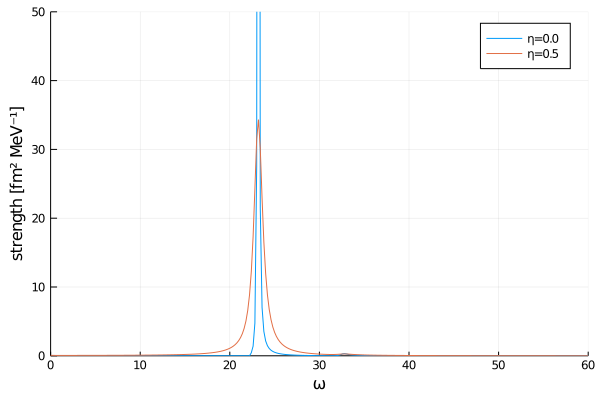

In [36]:
p=plot(xlabel="ω", ylabel="strength [fm² MeV⁻¹]", ylim=(0, 50))
plot!(ω, S₁, xlims=(0, 60), label="η=0.0")
plot!(ω, S₂; label="η=0.5")
p

In [115]:
pars = make_pars(82, 126; version=:SkM, κ=1 - 0.01)
L=1
mode = :dipole
ωmax=30
ωmin = 0
κ=0.554

#=
@time ω, S₁ = continuum_RPA_calc(pars, rs; 
    L=L, mode=mode, κ=κ, ωmax=ωmax, ωmin=ωmin)
=#

@time ω, S₂ = continuum_RPA_calc(pars, rs; 
    L=L, mode=mode, κ=κ, ωmax=ωmax, ωmin=ωmin, η=0.5)
;

calc_skin(pars, rs, dens) = 0.15890468596719476
 20.628118 seconds (126.42 M allocations: 13.938 GiB, 13.89% gc time)


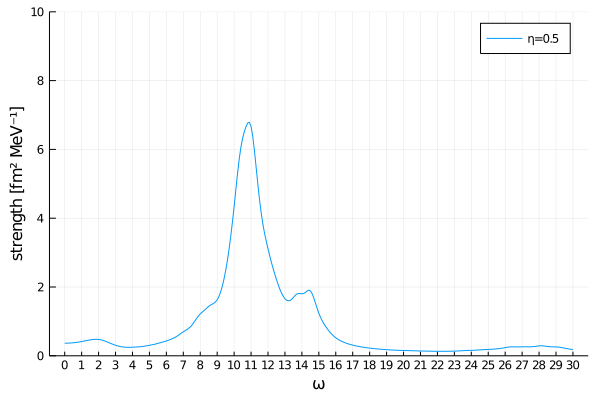

In [116]:
p=plot(xlabel="ω", ylabel="strength [fm² MeV⁻¹]", ylim=(0, 10), xtick=0:30)
#plot!(ω, S₁, xlims=(0, 60), label="η=0.0")
plot!(ω, S₂; label="η=0.5")
p

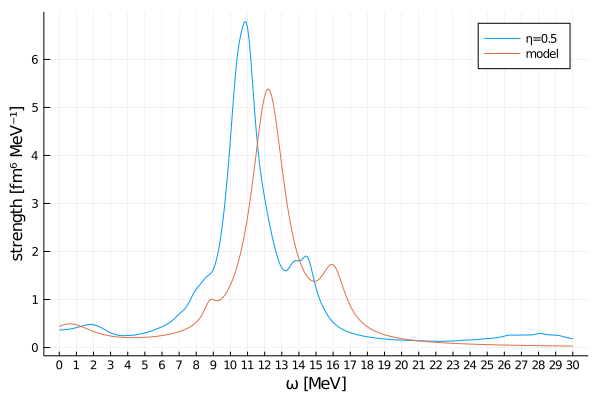

In [117]:
p_SkM = Float64[
    0, 2, 0.5,
    9, 1, 1, 
    12, 1, 5.5*1π, 
    14.8, 0.7, 2,
    16, 0.6, 3, 
    30, 3, 3*0.2π]

p₀= Float64[
    0.59, 1.7, 2.3, 
    8.8, 0.45, 0.52,
    12.2, 1.2, 20, 
    16, 0.9, 3.5
]

p=plot(xlabel="ω [MeV]", ylabel="strength [fm⁶ MeV⁻¹]", xtick=0:30)
plot!(ω, S₂; label="η=0.5")
plot!(ω, model(ω, p₀); label="model")
p

In [118]:
fit = curve_fit(model, ω, S₂, p₀)

#=
relative_strength_SIII = 
    fit.param[6]/
    (fit.param[9] + fit.param[12] + fit.param[15] + fit.param[18] + fit.param[21])*100
@show relative_strength_SIII
=#

relative_strength_SkM = 
    fit.param[6]/
    (fit.param[9] + fit.param[12])*100
@show relative_strength_SkM

fit.param
show_param(fit.param)

relative_strength_SkM = 18.932505033419687
i = 1
ω₀ = -2.607271110739446, η = 6.194889423885879, S = 8.147394580614503

i = 2
ω₀ = 14.28428712676454, η = 0.8710079339188235, S = 3.685720699912837

i = 3
ω₀ = 10.793092746283017, η = 1.0277526579611673, S = 21.479218781183942

i = 4
ω₀ = 27.844333554009236, η = -2.6333290541367114, S = -2.011532421630377



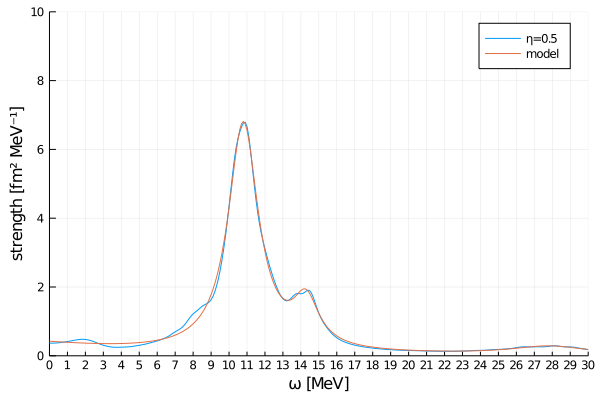

In [119]:
p=plot(xlabel="ω [MeV]", ylabel="strength [fm² MeV⁻¹]", 
    xtick=0:30, xlim=(0,30), ylim=(0, 10))
plot!(ω, S₂; label="η=0.5")
plot!(ω, model(ω, fit.param); label="model")
p